In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms as tfm
from sklearn import metrics as skmet
from jupyterplot import ProgressPlot

%aimport dataset
%aimport model
ImageData = dataset.ImageData
AE = model.AE_timm

In [19]:
kfold = 10  # number of folds in repeated k-fold
nrepeats = 1  # number of repeats in repeated k-fold
bs_train = 32  # batch size for training
bs_test = 50  # batch size for testing
num_workers = 10  # number of parallel data loading workers
res = 224 # pixel size along height and width
device = torch.device('cuda:0')
num_classes = 3
model = 'resnet50d'
num_epochs=30
lr = 0.001
lr_gamma = 0.9
dropout = 0.3
weight_decay = 0.001
pretrained=True
keep_views = ['AP_LIKE', 'Y', 'AXIL']
unfreeze_after_n=5
ckpt_path = f'/home/xiaofey/xray/xray-master/code/ae_{model}.ckpt'

In [20]:
df_img = pd.read_csv('../data/model_images.csv')
df_trg = pd.read_csv('../data/model_targets.csv')

In [21]:
cv = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=nrepeats)
splits = cv.split(df_trg, df_trg['fracture_type'])

In [22]:
tfms_train = tfm.Compose([
    tfm.Resize(res),
    tfm.CenterCrop(res),
    tfm.RandomEqualize(p=0.5),
    tfm.AutoAugment(),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.RandomHorizontalFlip(),
    tfm.RandomRotation((-45, 45)),
    tfm.RandomInvert(),
    tfm.Grayscale()
])

tfms_test = tfm.Compose([
    tfm.Resize(res),
    tfm.CenterCrop(res),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.Grayscale()
])

In [23]:
def compute_metrics(y_true, y_pred):
    mets = dict()
    
    y_pred_cls = np.argmax(y_pred, axis=-1)
    y_true_onehot = np.eye(num_classes, dtype=int)[y_true]
    
    mets['roc_auc'] = skmet.roc_auc_score(y_true_onehot, y_pred, multi_class='ovr')
    mets['average_precision'] = skmet.average_precision_score(y_true_onehot, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['balanced_accuracy'] = skmet.balanced_accuracy_score(y_true, y_pred_cls)
    
    return mets

In [24]:
def train_one_epoch(model, train_dataloader, loss_function, device):
    model.train()

    num_steps_per_epoch = len(train_dataloader)

    losses = []
    for ix, batch in enumerate(train_dataloader):
        inputs = batch['img'].to(device)
        targets = batch['trg'].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach().item())
        print(f"\tBatch {ix+1} of {num_steps_per_epoch}. Loss={loss.detach().item():0.3f}", end='\r')
    
    print(' '*100, end='\r')
        
    return np.mean(losses)
            
            
def evaluate(model, test_dataloader, loss_function, device):
    model.eval()

    num_steps_per_epoch = len(test_dataloader)

    target_ls = []
    output_ls = []
    losses = []
    for ix, batch in enumerate(test_dataloader):
        inputs = batch['img'].to(device)
        targets = batch['trg'].to(device)
        target_ls.append(targets.cpu().numpy())
        
        with torch.no_grad():
            outputs = model(inputs)
            output_ls.append(outputs.cpu().numpy())
            loss = loss_function(outputs, targets)
            
        losses.append(loss.detach().item())
    
    metrics = compute_metrics(np.concatenate(target_ls), np.concatenate(output_ls))
        
    return np.mean(losses), metrics

In [25]:
class Classifier(nn.Module):
    def __init__(self, ckpt, num_classes, test_img = torch.randn(1,1,32,32)):
        super(Classifier, self).__init__()
        
        # create autoencoder and load the state dict
        ae = AE(model)
        ae.load_state_dict(torch.load(ckpt))
        
        # pull off the encoder
        self.encoder = nn.Sequential(
            ae.encoder,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.ReLU()
        )
        
        # compute the hidden dimension from the test image
        self.h_dim = self.encoder(test_img).shape[-1]
        print(f"Using a hidden dimension of size {self.h_dim}")
        
        # create the classifier
        self.clf = nn.Sequential(
            nn.Linear(self.h_dim, num_classes),
        )
        
    def forward(self, x):
        h = self.encoder(x)
        x_hat = self.clf(h)
        return x_hat
    
test_img = torch.randn(3,1,res,res)
clf = Classifier(ckpt_path, 3, test_img=test_img)
clf(test_img)

The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


tensor([[ 0.0201,  0.0947,  0.0304],
        [ 0.1978,  0.1603, -0.1000],
        [ 0.1385, -0.0098, -0.0211]], grad_fn=<AddmmBackward0>)

In [26]:
split_results = []
splits = cv.split(df_trg, df_trg['fracture_type'])
for ix, (train_ix, test_ix) in enumerate(splits):
    print('-'*40)
    print('-'*40)
    print(f"Split {ix+1} of {kfold*nrepeats}.")
    df_train = df_trg.iloc[train_ix].merge(df_img)
    df_test = df_trg.iloc[test_ix].merge(df_img)
    
    # create datasets
    d_train = ImageData(df_train, transforms = tfms_train, view_filter=keep_views)
    dl_train = DataLoader(d_train, batch_size=bs_train, num_workers=num_workers, shuffle=True)
    
    
    d_test = ImageData(df_test, transforms = tfms_test, view_filter=keep_views)
    dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers)
    
    # create model
    m = Classifier(ckpt_path, num_classes, test_img)
    m.to(device)
    
    # freeze model weights
    # don't freeze classifier or first conv/bn
    for p in m.encoder.parameters():
        p.requires_grad = False
    is_frozen=True

    # fit
    optimizer = optim.AdamP(m.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=lr_gamma)
    loss_function = torch.functional.F.cross_entropy
    
    train_loss_ls = []
    test_loss_ls = []
    metrics_ls = []
    
    # progress plot
    pp_metrics = ProgressPlot(x_lim=[1,num_epochs], y_lim=[0,1], plot_names = ['metrics'], x_label="Epoch", line_names=['AUROC', 'Avg. Prec.', 'Acc.', 'Bal. Acc.'])
    
    for epoch in range(num_epochs):
        print("-"*40)
        print(f"Epoch {epoch+1} of {num_epochs}:")
        
        # maybe unfreeze 
        if epoch >= unfreeze_after_n and is_frozen:
            print("Unfreezing model encoder.")
            is_frozen=False
            for p in m.encoder.parameters():
                p.requires_grad = True
        
        # train for a single epoch
        train_loss = train_one_epoch(m, dl_train, loss_function, device)
        train_loss_ls.append(train_loss)
        print(f"Training:")
        print(f"\tcross_entropy = {train_loss:0.3f}")       
    
        # evaluate
        test_loss, metrics = evaluate(m, dl_test, loss_function, device)
        test_loss_ls.append(test_loss)
        metrics_ls.append(metrics)
        print(f"Test:")
        print(f"\tcross_entropy = {test_loss:0.3f}")
        for k, v in metrics.items():
            print(f"\t{k} = {v:0.3f}")
        
        scheduler.step()
        
        pp_metrics.update([[v for _,v in metrics.items()]])
        
    pp_metrics.finalize()
        
    split_results.append({'split_ix': ix, 'train_loss': train_loss_ls, 'test_loss': test_loss_ls, 'metrics': metrics_ls})

----------------------------------------
----------------------------------------
Split 1 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.120
Test:
	cross_entropy = 1.134
	roc_auc = 0.503
	average_precision = 0.370
	accuracy = 0.278
	balanced_accuracy = 0.300
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.108
Test:
	cross_entropy = 1.107
	roc_auc = 0.548
	average_precision = 0.391
	accuracy = 0.330
	balanced_accuracy = 0.351
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.088
Test:
	cross_entropy = 1.084
	roc_auc = 0.586
	average_precision = 0.435
	accuracy = 0.402
	balanced_accuracy = 0.408
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.067
Test:
	cross_entropy = 1.080
	roc_auc = 0.556
	average_precision = 0.411
	accuracy = 0.371
	balanced_accuracy = 0.354
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.061
Test:
	cross_entropy = 1.081
	roc_auc = 0.553
	average_precision = 0.412
	accuracy = 0.423
	balanced_accuracy = 0.397
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.043
Test:
	cross_entropy = 1.001
	roc_auc = 0.663
	average_precision = 0.509
	accuracy = 0.485
	balanced_accuracy = 0.468
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.007
Test:
	cross_entropy = 1.037
	roc_auc = 0.595
	average_precision = 0.437
	accuracy = 0.423
	balanced_accuracy = 0.416
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.978
Test:
	cross_entropy = 0.946
	roc_auc = 0.735
	average_precision = 0.578
	accuracy = 0.526
	balanced_accuracy = 0.499
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.951
Test:
	cross_entropy = 0.903
	roc_auc = 0.734
	average_precision = 0.580
	accuracy = 0.495
	balanced_accuracy = 0.489
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.888
Test:
	cross_entropy = 0.846
	roc_auc = 0.740
	average_precision = 0.601
	accuracy = 0.577
	balanced_accuracy = 0.561
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.855
Test:
	cross_entropy = 0.865
	roc_auc = 0.815
	average_precision = 0.649
	accuracy = 0.567
	balanced_accuracy = 0.565
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.826
Test:
	cross_entropy = 0.963
	roc_auc = 0.729
	average_precision = 0.628
	accuracy = 0.546
	balanced_accuracy = 0.530
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.796
Test:
	cross_entropy = 0.793
	roc_auc = 0.797
	average_precision = 0.674
	accuracy = 0.588
	balanced_accuracy = 0.579
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.718
Test:
	cross_entropy = 0.765
	roc_auc = 0.819
	average_precision = 0.680
	accuracy = 0.639
	balanced_accuracy = 0.630
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.682
Test:
	cross_entropy = 0.750
	roc_auc = 0.814
	average_precision = 0.683
	accuracy = 0.649
	balanced_accuracy = 0.631
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.636
Test:
	cross_entropy = 0.810
	roc_auc = 0.810
	average_precision = 0.681
	accuracy = 0.629
	balanced_accuracy = 0.617
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.607
Test:
	cross_entropy = 0.788
	roc_auc = 0.829
	average_precision = 0.672
	accuracy = 0.639
	balanced_accuracy = 0.622
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.538
Test:
	cross_entropy = 0.848
	roc_auc = 0.805
	average_precision = 0.661
	accuracy = 0.608
	balanced_accuracy = 0.597
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.548
Test:
	cross_entropy = 0.842
	roc_auc = 0.814
	average_precision = 0.659
	accuracy = 0.639
	balanced_accuracy = 0.622
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.468
Test:
	cross_entropy = 0.839
	roc_auc = 0.835
	average_precision = 0.681
	accuracy = 0.691
	balanced_accuracy = 0.677
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.454
Test:
	cross_entropy = 0.860
	roc_auc = 0.819
	average_precision = 0.663
	accuracy = 0.639
	balanced_accuracy = 0.622
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.411
Test:
	cross_entropy = 0.971
	roc_auc = 0.804
	average_precision = 0.642
	accuracy = 0.619
	balanced_accuracy = 0.602
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.388
Test:
	cross_entropy = 1.174
	roc_auc = 0.793
	average_precision = 0.625
	accuracy = 0.567
	balanced_accuracy = 0.548
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.358
Test:
	cross_entropy = 1.016
	roc_auc = 0.808
	average_precision = 0.649
	accuracy = 0.619
	balanced_accuracy = 0.606
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.347
Test:
	cross_entropy = 0.992
	roc_auc = 0.814
	average_precision = 0.669
	accuracy = 0.619
	balanced_accuracy = 0.604
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.313
Test:
	cross_entropy = 1.109
	roc_auc = 0.812
	average_precision = 0.662
	accuracy = 0.660
	balanced_accuracy = 0.650
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.291
Test:
	cross_entropy = 1.055
	roc_auc = 0.807
	average_precision = 0.661
	accuracy = 0.680
	balanced_accuracy = 0.666
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.255
Test:
	cross_entropy = 1.039
	roc_auc = 0.811
	average_precision = 0.656
	accuracy = 0.629
	balanced_accuracy = 0.613
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.251
Test:
	cross_entropy = 1.147
	roc_auc = 0.799
	average_precision = 0.656
	accuracy = 0.649
	balanced_accuracy = 0.635
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.245
Test:
	cross_entropy = 1.252
	roc_auc = 0.785
	average_precision = 0.643
	accuracy = 0.670
	balanced_accuracy = 0.659
----------------------------------------
----------------------------------------
Split 2 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.116
Test:
	cross_entropy = 1.070
	roc_auc = 0.581
	average_precision = 0.413
	accuracy = 0.356
	balanced_accuracy = 0.371
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.080
Test:
	cross_entropy = 1.015
	roc_auc = 0.581
	average_precision = 0.429
	accuracy = 0.396
	balanced_accuracy = 0.380
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.080
Test:
	cross_entropy = 1.013
	roc_auc = 0.585
	average_precision = 0.414
	accuracy = 0.446
	balanced_accuracy = 0.432
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.066
Test:
	cross_entropy = 0.965
	roc_auc = 0.552
	average_precision = 0.380
	accuracy = 0.406
	balanced_accuracy = 0.357
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.066
Test:
	cross_entropy = 0.988
	roc_auc = 0.585
	average_precision = 0.412
	accuracy = 0.386
	balanced_accuracy = 0.362
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.049
Test:
	cross_entropy = 1.095
	roc_auc = 0.599
	average_precision = 0.421
	accuracy = 0.406
	balanced_accuracy = 0.387
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.988
Test:
	cross_entropy = 0.941
	roc_auc = 0.609
	average_precision = 0.460
	accuracy = 0.426
	balanced_accuracy = 0.385
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.954
Test:
	cross_entropy = 0.943
	roc_auc = 0.683
	average_precision = 0.517
	accuracy = 0.406
	balanced_accuracy = 0.354
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.894
Test:
	cross_entropy = 0.886
	roc_auc = 0.741
	average_precision = 0.574
	accuracy = 0.515
	balanced_accuracy = 0.498
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.873
Test:
	cross_entropy = 0.859
	roc_auc = 0.750
	average_precision = 0.625
	accuracy = 0.554
	balanced_accuracy = 0.528
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.799
Test:
	cross_entropy = 0.822
	roc_auc = 0.787
	average_precision = 0.655
	accuracy = 0.614
	balanced_accuracy = 0.608
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.793
Test:
	cross_entropy = 0.843
	roc_auc = 0.724
	average_precision = 0.595
	accuracy = 0.545
	balanced_accuracy = 0.542
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.734
Test:
	cross_entropy = 0.808
	roc_auc = 0.716
	average_precision = 0.582
	accuracy = 0.485
	balanced_accuracy = 0.450
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.707
Test:
	cross_entropy = 0.828
	roc_auc = 0.742
	average_precision = 0.606
	accuracy = 0.545
	balanced_accuracy = 0.529
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.692
Test:
	cross_entropy = 0.658
	roc_auc = 0.778
	average_precision = 0.636
	accuracy = 0.554
	balanced_accuracy = 0.543
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.644
Test:
	cross_entropy = 0.731
	roc_auc = 0.737
	average_precision = 0.597
	accuracy = 0.525
	balanced_accuracy = 0.499
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.582
Test:
	cross_entropy = 0.820
	roc_auc = 0.744
	average_precision = 0.629
	accuracy = 0.594
	balanced_accuracy = 0.581
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.565
Test:
	cross_entropy = 0.702
	roc_auc = 0.756
	average_precision = 0.618
	accuracy = 0.535
	balanced_accuracy = 0.508
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.535
Test:
	cross_entropy = 0.734
	roc_auc = 0.730
	average_precision = 0.571
	accuracy = 0.525
	balanced_accuracy = 0.502
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.501
Test:
	cross_entropy = 0.776
	roc_auc = 0.736
	average_precision = 0.589
	accuracy = 0.554
	balanced_accuracy = 0.534
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.490
Test:
	cross_entropy = 0.787
	roc_auc = 0.741
	average_precision = 0.616
	accuracy = 0.525
	balanced_accuracy = 0.506
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.454
Test:
	cross_entropy = 0.819
	roc_auc = 0.746
	average_precision = 0.611
	accuracy = 0.594
	balanced_accuracy = 0.576
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.445
Test:
	cross_entropy = 0.855
	roc_auc = 0.739
	average_precision = 0.610
	accuracy = 0.554
	balanced_accuracy = 0.538
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.365
Test:
	cross_entropy = 0.917
	roc_auc = 0.728
	average_precision = 0.580
	accuracy = 0.535
	balanced_accuracy = 0.511
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.339
Test:
	cross_entropy = 0.872
	roc_auc = 0.744
	average_precision = 0.603
	accuracy = 0.564
	balanced_accuracy = 0.547
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.343
Test:
	cross_entropy = 0.892
	roc_auc = 0.742
	average_precision = 0.611
	accuracy = 0.554
	balanced_accuracy = 0.537
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.329
Test:
	cross_entropy = 0.838
	roc_auc = 0.757
	average_precision = 0.638
	accuracy = 0.574
	balanced_accuracy = 0.561
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.308
Test:
	cross_entropy = 0.832
	roc_auc = 0.763
	average_precision = 0.651
	accuracy = 0.554
	balanced_accuracy = 0.540
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.275
Test:
	cross_entropy = 0.884
	roc_auc = 0.744
	average_precision = 0.622
	accuracy = 0.574
	balanced_accuracy = 0.559
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.289
Test:
	cross_entropy = 0.958
	roc_auc = 0.719
	average_precision = 0.598
	accuracy = 0.574
	balanced_accuracy = 0.560
----------------------------------------
----------------------------------------
Split 3 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.110
Test:
	cross_entropy = 1.131
	roc_auc = 0.501
	average_precision = 0.340
	accuracy = 0.336
	balanced_accuracy = 0.341
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.084
Test:
	cross_entropy = 1.077
	roc_auc = 0.519
	average_precision = 0.400
	accuracy = 0.336
	balanced_accuracy = 0.328
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.076
Test:
	cross_entropy = 1.064
	roc_auc = 0.593
	average_precision = 0.436
	accuracy = 0.364
	balanced_accuracy = 0.356
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.063
Test:
	cross_entropy = 1.036
	roc_auc = 0.629
	average_precision = 0.492
	accuracy = 0.439
	balanced_accuracy = 0.426
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.072
Test:
	cross_entropy = 1.083
	roc_auc = 0.620
	average_precision = 0.481
	accuracy = 0.495
	balanced_accuracy = 0.500
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.056
Test:
	cross_entropy = 1.357
	roc_auc = 0.544
	average_precision = 0.399
	accuracy = 0.159
	balanced_accuracy = 0.164
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.984
Test:
	cross_entropy = 1.140
	roc_auc = 0.671
	average_precision = 0.524
	accuracy = 0.477
	balanced_accuracy = 0.476
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.960
Test:
	cross_entropy = 1.021
	roc_auc = 0.656
	average_precision = 0.505
	accuracy = 0.402
	balanced_accuracy = 0.390
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.882
Test:
	cross_entropy = 0.818
	roc_auc = 0.808
	average_precision = 0.683
	accuracy = 0.598
	balanced_accuracy = 0.592
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.860
Test:
	cross_entropy = 0.917
	roc_auc = 0.719
	average_precision = 0.577
	accuracy = 0.523
	balanced_accuracy = 0.511
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.810
Test:
	cross_entropy = 1.040
	roc_auc = 0.666
	average_precision = 0.553
	accuracy = 0.458
	balanced_accuracy = 0.455
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.780
Test:
	cross_entropy = 0.913
	roc_auc = 0.776
	average_precision = 0.666
	accuracy = 0.626
	balanced_accuracy = 0.627
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.759
Test:
	cross_entropy = 0.845
	roc_auc = 0.795
	average_precision = 0.691
	accuracy = 0.607
	balanced_accuracy = 0.602
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.676
Test:
	cross_entropy = 1.039
	roc_auc = 0.778
	average_precision = 0.677
	accuracy = 0.598
	balanced_accuracy = 0.597
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.634
Test:
	cross_entropy = 1.214
	roc_auc = 0.784
	average_precision = 0.684
	accuracy = 0.598
	balanced_accuracy = 0.602
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.663
Test:
	cross_entropy = 1.042
	roc_auc = 0.783
	average_precision = 0.693
	accuracy = 0.523
	balanced_accuracy = 0.523
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.564
Test:
	cross_entropy = 1.045
	roc_auc = 0.784
	average_precision = 0.688
	accuracy = 0.636
	balanced_accuracy = 0.635
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.531
Test:
	cross_entropy = 1.325
	roc_auc = 0.780
	average_precision = 0.666
	accuracy = 0.598
	balanced_accuracy = 0.597
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.523
Test:
	cross_entropy = 1.085
	roc_auc = 0.815
	average_precision = 0.713
	accuracy = 0.607
	balanced_accuracy = 0.609
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.469
Test:
	cross_entropy = 1.201
	roc_auc = 0.781
	average_precision = 0.674
	accuracy = 0.626
	balanced_accuracy = 0.629
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.427
Test:
	cross_entropy = 1.360
	roc_auc = 0.787
	average_precision = 0.686
	accuracy = 0.636
	balanced_accuracy = 0.639
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.405
Test:
	cross_entropy = 1.447
	roc_auc = 0.774
	average_precision = 0.661
	accuracy = 0.617
	balanced_accuracy = 0.617
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.388
Test:
	cross_entropy = 1.751
	roc_auc = 0.782
	average_precision = 0.667
	accuracy = 0.598
	balanced_accuracy = 0.598
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.371
Test:
	cross_entropy = 1.519
	roc_auc = 0.809
	average_precision = 0.704
	accuracy = 0.636
	balanced_accuracy = 0.639
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.355
Test:
	cross_entropy = 1.240
	roc_auc = 0.814
	average_precision = 0.720
	accuracy = 0.645
	balanced_accuracy = 0.648
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.343
Test:
	cross_entropy = 1.271
	roc_auc = 0.811
	average_precision = 0.713
	accuracy = 0.626
	balanced_accuracy = 0.625
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.339
Test:
	cross_entropy = 1.238
	roc_auc = 0.819
	average_precision = 0.719
	accuracy = 0.692
	balanced_accuracy = 0.692
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.264
Test:
	cross_entropy = 1.505
	roc_auc = 0.804
	average_precision = 0.699
	accuracy = 0.626
	balanced_accuracy = 0.628
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.258
Test:
	cross_entropy = 1.518
	roc_auc = 0.807
	average_precision = 0.700
	accuracy = 0.673
	balanced_accuracy = 0.675
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.253
Test:
	cross_entropy = 1.547
	roc_auc = 0.804
	average_precision = 0.698
	accuracy = 0.654
	balanced_accuracy = 0.657
----------------------------------------
----------------------------------------
Split 4 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.104
Test:
	cross_entropy = 1.088
	roc_auc = 0.578
	average_precision = 0.407
	accuracy = 0.430
	balanced_accuracy = 0.427
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.088
Test:
	cross_entropy = 1.077
	roc_auc = 0.608
	average_precision = 0.444
	accuracy = 0.450
	balanced_accuracy = 0.448
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.088
Test:
	cross_entropy = 1.080
	roc_auc = 0.617
	average_precision = 0.439
	accuracy = 0.390
	balanced_accuracy = 0.393
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.060
Test:
	cross_entropy = 1.062
	roc_auc = 0.639
	average_precision = 0.469
	accuracy = 0.440
	balanced_accuracy = 0.440
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.056
Test:
	cross_entropy = 1.067
	roc_auc = 0.631
	average_precision = 0.468
	accuracy = 0.440
	balanced_accuracy = 0.442
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.065
Test:
	cross_entropy = 1.169
	roc_auc = 0.552
	average_precision = 0.413
	accuracy = 0.370
	balanced_accuracy = 0.374
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.029
Test:
	cross_entropy = 1.018
	roc_auc = 0.684
	average_precision = 0.523
	accuracy = 0.420
	balanced_accuracy = 0.423
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.938
Test:
	cross_entropy = 0.980
	roc_auc = 0.702
	average_precision = 0.547
	accuracy = 0.460
	balanced_accuracy = 0.462
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.918
Test:
	cross_entropy = 0.973
	roc_auc = 0.717
	average_precision = 0.576
	accuracy = 0.500
	balanced_accuracy = 0.500
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.892
Test:
	cross_entropy = 0.998
	roc_auc = 0.715
	average_precision = 0.571
	accuracy = 0.510
	balanced_accuracy = 0.512
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.837
Test:
	cross_entropy = 0.993
	roc_auc = 0.713
	average_precision = 0.551
	accuracy = 0.510
	balanced_accuracy = 0.509
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.771
Test:
	cross_entropy = 0.928
	roc_auc = 0.732
	average_precision = 0.577
	accuracy = 0.500
	balanced_accuracy = 0.501
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.758
Test:
	cross_entropy = 1.041
	roc_auc = 0.720
	average_precision = 0.584
	accuracy = 0.530
	balanced_accuracy = 0.530
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.745
Test:
	cross_entropy = 1.200
	roc_auc = 0.744
	average_precision = 0.624
	accuracy = 0.530
	balanced_accuracy = 0.531
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.696
Test:
	cross_entropy = 1.111
	roc_auc = 0.739
	average_precision = 0.601
	accuracy = 0.540
	balanced_accuracy = 0.542
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.653
Test:
	cross_entropy = 1.172
	roc_auc = 0.670
	average_precision = 0.554
	accuracy = 0.500
	balanced_accuracy = 0.502
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.648
Test:
	cross_entropy = 0.860
	roc_auc = 0.777
	average_precision = 0.671
	accuracy = 0.580
	balanced_accuracy = 0.582
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.587
Test:
	cross_entropy = 0.940
	roc_auc = 0.763
	average_precision = 0.646
	accuracy = 0.560
	balanced_accuracy = 0.562
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.537
Test:
	cross_entropy = 0.969
	roc_auc = 0.770
	average_precision = 0.647
	accuracy = 0.580
	balanced_accuracy = 0.583
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.506
Test:
	cross_entropy = 0.963
	roc_auc = 0.771
	average_precision = 0.668
	accuracy = 0.620
	balanced_accuracy = 0.622
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.468
Test:
	cross_entropy = 0.900
	roc_auc = 0.766
	average_precision = 0.670
	accuracy = 0.570
	balanced_accuracy = 0.571
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.445
Test:
	cross_entropy = 0.925
	roc_auc = 0.770
	average_precision = 0.674
	accuracy = 0.660
	balanced_accuracy = 0.662
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.429
Test:
	cross_entropy = 1.032
	roc_auc = 0.764
	average_precision = 0.656
	accuracy = 0.630
	balanced_accuracy = 0.631
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.398
Test:
	cross_entropy = 1.034
	roc_auc = 0.762
	average_precision = 0.660
	accuracy = 0.570
	balanced_accuracy = 0.572
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.325
Test:
	cross_entropy = 1.060
	roc_auc = 0.765
	average_precision = 0.665
	accuracy = 0.610
	balanced_accuracy = 0.612
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.352
Test:
	cross_entropy = 1.036
	roc_auc = 0.777
	average_precision = 0.675
	accuracy = 0.620
	balanced_accuracy = 0.621
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.299
Test:
	cross_entropy = 0.951
	roc_auc = 0.799
	average_precision = 0.696
	accuracy = 0.680
	balanced_accuracy = 0.680
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.337
Test:
	cross_entropy = 1.014
	roc_auc = 0.783
	average_precision = 0.676
	accuracy = 0.620
	balanced_accuracy = 0.621
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.314
Test:
	cross_entropy = 0.996
	roc_auc = 0.790
	average_precision = 0.691
	accuracy = 0.630
	balanced_accuracy = 0.631
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.248
Test:
	cross_entropy = 1.101
	roc_auc = 0.782
	average_precision = 0.666
	accuracy = 0.610
	balanced_accuracy = 0.611
----------------------------------------
----------------------------------------
Split 5 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.110
Test:
	cross_entropy = 1.108
	roc_auc = 0.539
	average_precision = 0.417
	accuracy = 0.380
	balanced_accuracy = 0.369
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.079
Test:
	cross_entropy = 1.149
	roc_auc = 0.525
	average_precision = 0.397
	accuracy = 0.343
	balanced_accuracy = 0.333
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.093
Test:
	cross_entropy = 1.157
	roc_auc = 0.517
	average_precision = 0.393
	accuracy = 0.333
	balanced_accuracy = 0.330
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.079
Test:
	cross_entropy = 1.114
	roc_auc = 0.523
	average_precision = 0.403
	accuracy = 0.389
	balanced_accuracy = 0.409
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.064
Test:
	cross_entropy = 1.099
	roc_auc = 0.540
	average_precision = 0.408
	accuracy = 0.417
	balanced_accuracy = 0.416
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.076
Test:
	cross_entropy = 1.159
	roc_auc = 0.483
	average_precision = 0.339
	accuracy = 0.296
	balanced_accuracy = 0.298
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.026
Test:
	cross_entropy = 1.120
	roc_auc = 0.572
	average_precision = 0.435
	accuracy = 0.407
	balanced_accuracy = 0.402
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.994
Test:
	cross_entropy = 1.111
	roc_auc = 0.647
	average_precision = 0.517
	accuracy = 0.407
	balanced_accuracy = 0.400
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.906
Test:
	cross_entropy = 1.140
	roc_auc = 0.636
	average_precision = 0.484
	accuracy = 0.343
	balanced_accuracy = 0.341
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.885
Test:
	cross_entropy = 1.055
	roc_auc = 0.708
	average_precision = 0.575
	accuracy = 0.481
	balanced_accuracy = 0.483
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.871
Test:
	cross_entropy = 1.058
	roc_auc = 0.688
	average_precision = 0.553
	accuracy = 0.417
	balanced_accuracy = 0.420
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.803
Test:
	cross_entropy = 0.993
	roc_auc = 0.730
	average_precision = 0.589
	accuracy = 0.556
	balanced_accuracy = 0.559
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.749
Test:
	cross_entropy = 0.988
	roc_auc = 0.745
	average_precision = 0.632
	accuracy = 0.546
	balanced_accuracy = 0.556
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.713
Test:
	cross_entropy = 1.141
	roc_auc = 0.725
	average_precision = 0.597
	accuracy = 0.528
	balanced_accuracy = 0.526
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.675
Test:
	cross_entropy = 1.046
	roc_auc = 0.745
	average_precision = 0.624
	accuracy = 0.574
	balanced_accuracy = 0.583
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.652
Test:
	cross_entropy = 1.155
	roc_auc = 0.755
	average_precision = 0.659
	accuracy = 0.602
	balanced_accuracy = 0.612
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.571
Test:
	cross_entropy = 1.337
	roc_auc = 0.739
	average_precision = 0.634
	accuracy = 0.574
	balanced_accuracy = 0.583
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.545
Test:
	cross_entropy = 1.338
	roc_auc = 0.751
	average_precision = 0.637
	accuracy = 0.556
	balanced_accuracy = 0.544
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.526
Test:
	cross_entropy = 1.208
	roc_auc = 0.740
	average_precision = 0.620
	accuracy = 0.546
	balanced_accuracy = 0.542
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.474
Test:
	cross_entropy = 1.428
	roc_auc = 0.736
	average_precision = 0.615
	accuracy = 0.537
	balanced_accuracy = 0.553
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.414
Test:
	cross_entropy = 1.579
	roc_auc = 0.735
	average_precision = 0.607
	accuracy = 0.593
	balanced_accuracy = 0.607
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.375
Test:
	cross_entropy = 1.577
	roc_auc = 0.725
	average_precision = 0.598
	accuracy = 0.556
	balanced_accuracy = 0.558
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.371
Test:
	cross_entropy = 1.566
	roc_auc = 0.732
	average_precision = 0.624
	accuracy = 0.565
	balanced_accuracy = 0.564
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.380
Test:
	cross_entropy = 1.460
	roc_auc = 0.742
	average_precision = 0.616
	accuracy = 0.565
	balanced_accuracy = 0.571
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.335
Test:
	cross_entropy = 1.548
	roc_auc = 0.724
	average_precision = 0.604
	accuracy = 0.583
	balanced_accuracy = 0.595
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.314
Test:
	cross_entropy = 1.626
	roc_auc = 0.736
	average_precision = 0.624
	accuracy = 0.593
	balanced_accuracy = 0.597
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.263
Test:
	cross_entropy = 1.586
	roc_auc = 0.742
	average_precision = 0.634
	accuracy = 0.546
	balanced_accuracy = 0.547
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.240
Test:
	cross_entropy = 1.682
	roc_auc = 0.744
	average_precision = 0.628
	accuracy = 0.556
	balanced_accuracy = 0.554
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.221
Test:
	cross_entropy = 1.649
	roc_auc = 0.736
	average_precision = 0.622
	accuracy = 0.583
	balanced_accuracy = 0.585
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.272
Test:
	cross_entropy = 1.685
	roc_auc = 0.748
	average_precision = 0.636
	accuracy = 0.602
	balanced_accuracy = 0.607
----------------------------------------
----------------------------------------
Split 6 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.124
Test:
	cross_entropy = 1.059
	roc_auc = 0.617
	average_precision = 0.460
	accuracy = 0.451
	balanced_accuracy = 0.451
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.094
Test:
	cross_entropy = 1.077
	roc_auc = 0.656
	average_precision = 0.482
	accuracy = 0.490
	balanced_accuracy = 0.483
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.088
Test:
	cross_entropy = 1.108
	roc_auc = 0.651
	average_precision = 0.479
	accuracy = 0.373
	balanced_accuracy = 0.365
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.067
Test:
	cross_entropy = 1.046
	roc_auc = 0.656
	average_precision = 0.531
	accuracy = 0.471
	balanced_accuracy = 0.458
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.057
Test:
	cross_entropy = 1.014
	roc_auc = 0.651
	average_precision = 0.523
	accuracy = 0.422
	balanced_accuracy = 0.423
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.076
Test:
	cross_entropy = 1.008
	roc_auc = 0.655
	average_precision = 0.495
	accuracy = 0.471
	balanced_accuracy = 0.457
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.994
Test:
	cross_entropy = 0.997
	roc_auc = 0.655
	average_precision = 0.484
	accuracy = 0.441
	balanced_accuracy = 0.444
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.970
Test:
	cross_entropy = 0.916
	roc_auc = 0.691
	average_precision = 0.547
	accuracy = 0.441
	balanced_accuracy = 0.434
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.943
Test:
	cross_entropy = 1.280
	roc_auc = 0.685
	average_precision = 0.530
	accuracy = 0.412
	balanced_accuracy = 0.414
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.869
Test:
	cross_entropy = 1.182
	roc_auc = 0.676
	average_precision = 0.524
	accuracy = 0.441
	balanced_accuracy = 0.431
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.870
Test:
	cross_entropy = 0.950
	roc_auc = 0.680
	average_precision = 0.532
	accuracy = 0.480
	balanced_accuracy = 0.470
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.814
Test:
	cross_entropy = 0.852
	roc_auc = 0.754
	average_precision = 0.624
	accuracy = 0.578
	balanced_accuracy = 0.581
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.712
Test:
	cross_entropy = 0.931
	roc_auc = 0.704
	average_precision = 0.552
	accuracy = 0.480
	balanced_accuracy = 0.480
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.733
Test:
	cross_entropy = 0.913
	roc_auc = 0.748
	average_precision = 0.624
	accuracy = 0.598
	balanced_accuracy = 0.597
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.671
Test:
	cross_entropy = 0.875
	roc_auc = 0.742
	average_precision = 0.619
	accuracy = 0.510
	balanced_accuracy = 0.513
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.620
Test:
	cross_entropy = 0.881
	roc_auc = 0.752
	average_precision = 0.592
	accuracy = 0.578
	balanced_accuracy = 0.576
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.633
Test:
	cross_entropy = 0.914
	roc_auc = 0.737
	average_precision = 0.606
	accuracy = 0.588
	balanced_accuracy = 0.582
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.565
Test:
	cross_entropy = 1.088
	roc_auc = 0.739
	average_precision = 0.597
	accuracy = 0.578
	balanced_accuracy = 0.576
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.519
Test:
	cross_entropy = 1.143
	roc_auc = 0.753
	average_precision = 0.618
	accuracy = 0.549
	balanced_accuracy = 0.549
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.505
Test:
	cross_entropy = 1.267
	roc_auc = 0.744
	average_precision = 0.599
	accuracy = 0.578
	balanced_accuracy = 0.574
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.469
Test:
	cross_entropy = 1.206
	roc_auc = 0.720
	average_precision = 0.587
	accuracy = 0.500
	balanced_accuracy = 0.496
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.423
Test:
	cross_entropy = 1.253
	roc_auc = 0.744
	average_precision = 0.602
	accuracy = 0.529
	balanced_accuracy = 0.525
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.363
Test:
	cross_entropy = 1.088
	roc_auc = 0.751
	average_precision = 0.628
	accuracy = 0.539
	balanced_accuracy = 0.537
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.359
Test:
	cross_entropy = 1.057
	roc_auc = 0.743
	average_precision = 0.617
	accuracy = 0.559
	balanced_accuracy = 0.553
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.352
Test:
	cross_entropy = 1.133
	roc_auc = 0.749
	average_precision = 0.627
	accuracy = 0.549
	balanced_accuracy = 0.544
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.313
Test:
	cross_entropy = 1.180
	roc_auc = 0.754
	average_precision = 0.632
	accuracy = 0.539
	balanced_accuracy = 0.535
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.291
Test:
	cross_entropy = 1.213
	roc_auc = 0.743
	average_precision = 0.625
	accuracy = 0.559
	balanced_accuracy = 0.554
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.287
Test:
	cross_entropy = 1.188
	roc_auc = 0.735
	average_precision = 0.624
	accuracy = 0.529
	balanced_accuracy = 0.524
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.315
Test:
	cross_entropy = 1.198
	roc_auc = 0.740
	average_precision = 0.625
	accuracy = 0.539
	balanced_accuracy = 0.535
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.249
Test:
	cross_entropy = 1.177
	roc_auc = 0.755
	average_precision = 0.620
	accuracy = 0.539
	balanced_accuracy = 0.534
----------------------------------------
----------------------------------------
Split 7 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.105
Test:
	cross_entropy = 1.103
	roc_auc = 0.524
	average_precision = 0.370
	accuracy = 0.370
	balanced_accuracy = 0.350
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.077
Test:
	cross_entropy = 1.095
	roc_auc = 0.550
	average_precision = 0.393
	accuracy = 0.380
	balanced_accuracy = 0.361
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.078
Test:
	cross_entropy = 1.107
	roc_auc = 0.553
	average_precision = 0.394
	accuracy = 0.360
	balanced_accuracy = 0.343
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.073
Test:
	cross_entropy = 1.092
	roc_auc = 0.580
	average_precision = 0.426
	accuracy = 0.400
	balanced_accuracy = 0.377
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.055
Test:
	cross_entropy = 1.092
	roc_auc = 0.563
	average_precision = 0.400
	accuracy = 0.390
	balanced_accuracy = 0.369
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.049
Test:
	cross_entropy = 1.150
	roc_auc = 0.529
	average_precision = 0.390
	accuracy = 0.320
	balanced_accuracy = 0.306
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.979
Test:
	cross_entropy = 1.111
	roc_auc = 0.547
	average_precision = 0.407
	accuracy = 0.380
	balanced_accuracy = 0.378
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.956
Test:
	cross_entropy = 1.065
	roc_auc = 0.645
	average_precision = 0.497
	accuracy = 0.420
	balanced_accuracy = 0.407
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.928
Test:
	cross_entropy = 0.960
	roc_auc = 0.719
	average_precision = 0.569
	accuracy = 0.520
	balanced_accuracy = 0.502
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.898
Test:
	cross_entropy = 1.034
	roc_auc = 0.673
	average_precision = 0.533
	accuracy = 0.550
	balanced_accuracy = 0.542
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.852
Test:
	cross_entropy = 0.981
	roc_auc = 0.706
	average_precision = 0.566
	accuracy = 0.510
	balanced_accuracy = 0.492
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.808
Test:
	cross_entropy = 0.914
	roc_auc = 0.754
	average_precision = 0.658
	accuracy = 0.570
	balanced_accuracy = 0.573
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.761
Test:
	cross_entropy = 0.895
	roc_auc = 0.763
	average_precision = 0.650
	accuracy = 0.540
	balanced_accuracy = 0.525
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.726
Test:
	cross_entropy = 0.866
	roc_auc = 0.787
	average_precision = 0.683
	accuracy = 0.620
	balanced_accuracy = 0.616
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.682
Test:
	cross_entropy = 0.884
	roc_auc = 0.788
	average_precision = 0.655
	accuracy = 0.610
	balanced_accuracy = 0.602
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.660
Test:
	cross_entropy = 0.870
	roc_auc = 0.805
	average_precision = 0.675
	accuracy = 0.570
	balanced_accuracy = 0.549
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.622
Test:
	cross_entropy = 0.861
	roc_auc = 0.812
	average_precision = 0.689
	accuracy = 0.600
	balanced_accuracy = 0.595
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.558
Test:
	cross_entropy = 1.108
	roc_auc = 0.774
	average_precision = 0.624
	accuracy = 0.560
	balanced_accuracy = 0.556
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.557
Test:
	cross_entropy = 1.033
	roc_auc = 0.764
	average_precision = 0.624
	accuracy = 0.530
	balanced_accuracy = 0.519
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.501
Test:
	cross_entropy = 0.954
	roc_auc = 0.805
	average_precision = 0.674
	accuracy = 0.600
	balanced_accuracy = 0.594
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.449
Test:
	cross_entropy = 1.079
	roc_auc = 0.789
	average_precision = 0.649
	accuracy = 0.580
	balanced_accuracy = 0.573
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.436
Test:
	cross_entropy = 0.931
	roc_auc = 0.821
	average_precision = 0.686
	accuracy = 0.660
	balanced_accuracy = 0.650
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.399
Test:
	cross_entropy = 1.003
	roc_auc = 0.814
	average_precision = 0.674
	accuracy = 0.570
	balanced_accuracy = 0.564
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.390
Test:
	cross_entropy = 1.059
	roc_auc = 0.792
	average_precision = 0.658
	accuracy = 0.610
	balanced_accuracy = 0.606
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.336
Test:
	cross_entropy = 1.022
	roc_auc = 0.810
	average_precision = 0.676
	accuracy = 0.640
	balanced_accuracy = 0.636
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.339
Test:
	cross_entropy = 1.031
	roc_auc = 0.815
	average_precision = 0.674
	accuracy = 0.650
	balanced_accuracy = 0.646
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.317
Test:
	cross_entropy = 1.155
	roc_auc = 0.773
	average_precision = 0.626
	accuracy = 0.600
	balanced_accuracy = 0.589
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.328
Test:
	cross_entropy = 1.160
	roc_auc = 0.792
	average_precision = 0.651
	accuracy = 0.600
	balanced_accuracy = 0.591
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.304
Test:
	cross_entropy = 1.078
	roc_auc = 0.804
	average_precision = 0.666
	accuracy = 0.590
	balanced_accuracy = 0.585
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.288
Test:
	cross_entropy = 1.090
	roc_auc = 0.795
	average_precision = 0.656
	accuracy = 0.600
	balanced_accuracy = 0.594
----------------------------------------
----------------------------------------
Split 8 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.105
Test:
	cross_entropy = 1.095
	roc_auc = 0.543
	average_precision = 0.418
	accuracy = 0.388
	balanced_accuracy = 0.402
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.081
Test:
	cross_entropy = 1.089
	roc_auc = 0.584
	average_precision = 0.442
	accuracy = 0.357
	balanced_accuracy = 0.377
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.077
Test:
	cross_entropy = 1.074
	roc_auc = 0.598
	average_precision = 0.465
	accuracy = 0.378
	balanced_accuracy = 0.388
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.062
Test:
	cross_entropy = 1.065
	roc_auc = 0.594
	average_precision = 0.452
	accuracy = 0.429
	balanced_accuracy = 0.424
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.055
Test:
	cross_entropy = 1.068
	roc_auc = 0.610
	average_precision = 0.465
	accuracy = 0.398
	balanced_accuracy = 0.407
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.078
Test:
	cross_entropy = 1.000
	roc_auc = 0.711
	average_precision = 0.545
	accuracy = 0.510
	balanced_accuracy = 0.498
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.020
Test:
	cross_entropy = 0.964
	roc_auc = 0.710
	average_precision = 0.564
	accuracy = 0.510
	balanced_accuracy = 0.501
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.968
Test:
	cross_entropy = 0.914
	roc_auc = 0.736
	average_precision = 0.583
	accuracy = 0.520
	balanced_accuracy = 0.530
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.921
Test:
	cross_entropy = 1.016
	roc_auc = 0.726
	average_precision = 0.523
	accuracy = 0.500
	balanced_accuracy = 0.475
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.897
Test:
	cross_entropy = 0.995
	roc_auc = 0.697
	average_precision = 0.552
	accuracy = 0.469
	balanced_accuracy = 0.467
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.830
Test:
	cross_entropy = 0.902
	roc_auc = 0.748
	average_precision = 0.595
	accuracy = 0.531
	balanced_accuracy = 0.533
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.797
Test:
	cross_entropy = 0.879
	roc_auc = 0.787
	average_precision = 0.663
	accuracy = 0.592
	balanced_accuracy = 0.577
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.800
Test:
	cross_entropy = 0.987
	roc_auc = 0.717
	average_precision = 0.593
	accuracy = 0.510
	balanced_accuracy = 0.504
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.724
Test:
	cross_entropy = 0.782
	roc_auc = 0.798
	average_precision = 0.687
	accuracy = 0.592
	balanced_accuracy = 0.588
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.670
Test:
	cross_entropy = 0.798
	roc_auc = 0.799
	average_precision = 0.663
	accuracy = 0.673
	balanced_accuracy = 0.674
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.607
Test:
	cross_entropy = 0.767
	roc_auc = 0.831
	average_precision = 0.700
	accuracy = 0.571
	balanced_accuracy = 0.576
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.621
Test:
	cross_entropy = 0.921
	roc_auc = 0.791
	average_precision = 0.642
	accuracy = 0.561
	balanced_accuracy = 0.568
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.563
Test:
	cross_entropy = 0.890
	roc_auc = 0.812
	average_precision = 0.696
	accuracy = 0.622
	balanced_accuracy = 0.632
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.545
Test:
	cross_entropy = 0.906
	roc_auc = 0.812
	average_precision = 0.667
	accuracy = 0.633
	balanced_accuracy = 0.630
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.501
Test:
	cross_entropy = 0.916
	roc_auc = 0.809
	average_precision = 0.689
	accuracy = 0.633
	balanced_accuracy = 0.634
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.485
Test:
	cross_entropy = 0.980
	roc_auc = 0.808
	average_precision = 0.662
	accuracy = 0.633
	balanced_accuracy = 0.642
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.424
Test:
	cross_entropy = 1.172
	roc_auc = 0.801
	average_precision = 0.669
	accuracy = 0.612
	balanced_accuracy = 0.623
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.402
Test:
	cross_entropy = 1.002
	roc_auc = 0.824
	average_precision = 0.696
	accuracy = 0.622
	balanced_accuracy = 0.631
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.384
Test:
	cross_entropy = 1.161
	roc_auc = 0.819
	average_precision = 0.680
	accuracy = 0.633
	balanced_accuracy = 0.641
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.364
Test:
	cross_entropy = 0.940
	roc_auc = 0.815
	average_precision = 0.680
	accuracy = 0.592
	balanced_accuracy = 0.592
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.338
Test:
	cross_entropy = 1.023
	roc_auc = 0.812
	average_precision = 0.688
	accuracy = 0.582
	balanced_accuracy = 0.588
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.318
Test:
	cross_entropy = 1.009
	roc_auc = 0.823
	average_precision = 0.687
	accuracy = 0.582
	balanced_accuracy = 0.588
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.344
Test:
	cross_entropy = 0.998
	roc_auc = 0.822
	average_precision = 0.685
	accuracy = 0.592
	balanced_accuracy = 0.596
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.277
Test:
	cross_entropy = 1.044
	roc_auc = 0.823
	average_precision = 0.689
	accuracy = 0.612
	balanced_accuracy = 0.619
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.260
Test:
	cross_entropy = 1.146
	roc_auc = 0.811
	average_precision = 0.677
	accuracy = 0.612
	balanced_accuracy = 0.621
----------------------------------------
----------------------------------------
Split 9 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.104
Test:
	cross_entropy = 1.108
	roc_auc = 0.531
	average_precision = 0.400
	accuracy = 0.304
	balanced_accuracy = 0.321
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.093
Test:
	cross_entropy = 1.051
	roc_auc = 0.621
	average_precision = 0.472
	accuracy = 0.451
	balanced_accuracy = 0.449
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.063
Test:
	cross_entropy = 1.007
	roc_auc = 0.689
	average_precision = 0.503
	accuracy = 0.500
	balanced_accuracy = 0.481
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.068
Test:
	cross_entropy = 1.059
	roc_auc = 0.651
	average_precision = 0.495
	accuracy = 0.441
	balanced_accuracy = 0.458
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.077
Test:
	cross_entropy = 1.007
	roc_auc = 0.673
	average_precision = 0.519
	accuracy = 0.471
	balanced_accuracy = 0.474
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.070
Test:
	cross_entropy = 0.961
	roc_auc = 0.673
	average_precision = 0.562
	accuracy = 0.471
	balanced_accuracy = 0.482
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.005
Test:
	cross_entropy = 0.829
	roc_auc = 0.676
	average_precision = 0.551
	accuracy = 0.490
	balanced_accuracy = 0.480
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.964
Test:
	cross_entropy = 0.815
	roc_auc = 0.705
	average_precision = 0.548
	accuracy = 0.480
	balanced_accuracy = 0.469
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.929
Test:
	cross_entropy = 0.859
	roc_auc = 0.714
	average_precision = 0.548
	accuracy = 0.480
	balanced_accuracy = 0.490
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.893
Test:
	cross_entropy = 0.801
	roc_auc = 0.718
	average_precision = 0.579
	accuracy = 0.471
	balanced_accuracy = 0.455
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.864
Test:
	cross_entropy = 0.845
	roc_auc = 0.713
	average_precision = 0.570
	accuracy = 0.500
	balanced_accuracy = 0.497
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.799
Test:
	cross_entropy = 0.661
	roc_auc = 0.748
	average_precision = 0.606
	accuracy = 0.520
	balanced_accuracy = 0.519
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.765
Test:
	cross_entropy = 0.701
	roc_auc = 0.766
	average_precision = 0.591
	accuracy = 0.539
	balanced_accuracy = 0.534
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.715
Test:
	cross_entropy = 0.702
	roc_auc = 0.743
	average_precision = 0.598
	accuracy = 0.510
	balanced_accuracy = 0.504
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.677
Test:
	cross_entropy = 0.696
	roc_auc = 0.777
	average_precision = 0.644
	accuracy = 0.578
	balanced_accuracy = 0.574
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.645
Test:
	cross_entropy = 0.808
	roc_auc = 0.738
	average_precision = 0.590
	accuracy = 0.539
	balanced_accuracy = 0.522
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.577
Test:
	cross_entropy = 0.718
	roc_auc = 0.810
	average_precision = 0.678
	accuracy = 0.598
	balanced_accuracy = 0.594
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.503
Test:
	cross_entropy = 0.848
	roc_auc = 0.788
	average_precision = 0.664
	accuracy = 0.598
	balanced_accuracy = 0.591
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.505
Test:
	cross_entropy = 0.833
	roc_auc = 0.783
	average_precision = 0.654
	accuracy = 0.549
	balanced_accuracy = 0.541
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.503
Test:
	cross_entropy = 0.933
	roc_auc = 0.744
	average_precision = 0.594
	accuracy = 0.520
	balanced_accuracy = 0.516
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.465
Test:
	cross_entropy = 0.704
	roc_auc = 0.795
	average_precision = 0.662
	accuracy = 0.608
	balanced_accuracy = 0.603
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.446
Test:
	cross_entropy = 0.914
	roc_auc = 0.765
	average_precision = 0.624
	accuracy = 0.569
	balanced_accuracy = 0.556
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.446
Test:
	cross_entropy = 0.760
	roc_auc = 0.793
	average_precision = 0.651
	accuracy = 0.529
	balanced_accuracy = 0.519
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.383
Test:
	cross_entropy = 0.821
	roc_auc = 0.789
	average_precision = 0.639
	accuracy = 0.559
	balanced_accuracy = 0.554
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.331
Test:
	cross_entropy = 0.715
	roc_auc = 0.810
	average_precision = 0.679
	accuracy = 0.598
	balanced_accuracy = 0.593
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.291
Test:
	cross_entropy = 0.867
	roc_auc = 0.779
	average_precision = 0.654
	accuracy = 0.578
	balanced_accuracy = 0.572
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.360
Test:
	cross_entropy = 0.926
	roc_auc = 0.755
	average_precision = 0.620
	accuracy = 0.578
	balanced_accuracy = 0.575
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.301
Test:
	cross_entropy = 0.851
	roc_auc = 0.774
	average_precision = 0.638
	accuracy = 0.559
	balanced_accuracy = 0.555
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.261
Test:
	cross_entropy = 0.852
	roc_auc = 0.777
	average_precision = 0.640
	accuracy = 0.618
	balanced_accuracy = 0.614
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.262
Test:
	cross_entropy = 0.793
	roc_auc = 0.798
	average_precision = 0.660
	accuracy = 0.618
	balanced_accuracy = 0.614
----------------------------------------
----------------------------------------
Split 10 of 10.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The given encoder outputs a feature map with 2048 channels
Using a hidden dimension of size 2048


----------------------------------------
Epoch 1 of 30:
Training:                                                                                           
	cross_entropy = 1.135
Test:
	cross_entropy = 1.109
	roc_auc = 0.520
	average_precision = 0.378
	accuracy = 0.364
	balanced_accuracy = 0.353
----------------------------------------
Epoch 2 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.075
Test:
	cross_entropy = 1.097
	roc_auc = 0.524
	average_precision = 0.371
	accuracy = 0.414
	balanced_accuracy = 0.403
----------------------------------------
Epoch 3 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.074
Test:
	cross_entropy = 1.091
	roc_auc = 0.591
	average_precision = 0.399
	accuracy = 0.343
	balanced_accuracy = 0.340
----------------------------------------
Epoch 4 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.067
Test:
	cross_entropy = 1.074
	roc_auc = 0.612
	average_precision = 0.448
	accuracy = 0.414
	balanced_accuracy = 0.416
----------------------------------------
Epoch 5 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.056
Test:
	cross_entropy = 1.068
	roc_auc = 0.626
	average_precision = 0.460
	accuracy = 0.444
	balanced_accuracy = 0.445
----------------------------------------
Epoch 6 of 30:
Unfreezing model encoder.


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 1.048
Test:
	cross_entropy = 1.106
	roc_auc = 0.568
	average_precision = 0.413
	accuracy = 0.414
	balanced_accuracy = 0.418
----------------------------------------
Epoch 7 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.984
Test:
	cross_entropy = 1.193
	roc_auc = 0.604
	average_precision = 0.418
	accuracy = 0.404
	balanced_accuracy = 0.405
----------------------------------------
Epoch 8 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.927
Test:
	cross_entropy = 1.104
	roc_auc = 0.601
	average_precision = 0.436
	accuracy = 0.364
	balanced_accuracy = 0.359
----------------------------------------
Epoch 9 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.915
Test:
	cross_entropy = 0.990
	roc_auc = 0.706
	average_precision = 0.577
	accuracy = 0.475
	balanced_accuracy = 0.485
----------------------------------------
Epoch 10 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.859
Test:
	cross_entropy = 1.083
	roc_auc = 0.665
	average_precision = 0.513
	accuracy = 0.424
	balanced_accuracy = 0.431
----------------------------------------
Epoch 11 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.794
Test:
	cross_entropy = 0.978
	roc_auc = 0.734
	average_precision = 0.611
	accuracy = 0.566
	balanced_accuracy = 0.562
----------------------------------------
Epoch 12 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.802
Test:
	cross_entropy = 1.110
	roc_auc = 0.659
	average_precision = 0.515
	accuracy = 0.394
	balanced_accuracy = 0.397
----------------------------------------
Epoch 13 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.760
Test:
	cross_entropy = 1.024
	roc_auc = 0.725
	average_precision = 0.607
	accuracy = 0.485
	balanced_accuracy = 0.490
----------------------------------------
Epoch 14 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.727
Test:
	cross_entropy = 0.982
	roc_auc = 0.738
	average_precision = 0.597
	accuracy = 0.505
	balanced_accuracy = 0.503
----------------------------------------
Epoch 15 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.667
Test:
	cross_entropy = 0.978
	roc_auc = 0.724
	average_precision = 0.591
	accuracy = 0.525
	balanced_accuracy = 0.525
----------------------------------------
Epoch 16 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.616
Test:
	cross_entropy = 1.141
	roc_auc = 0.723
	average_precision = 0.582
	accuracy = 0.545
	balanced_accuracy = 0.542
----------------------------------------
Epoch 17 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.578
Test:
	cross_entropy = 1.108
	roc_auc = 0.732
	average_precision = 0.600
	accuracy = 0.556
	balanced_accuracy = 0.548
----------------------------------------
Epoch 18 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.548
Test:
	cross_entropy = 1.030
	roc_auc = 0.735
	average_precision = 0.608
	accuracy = 0.525
	balanced_accuracy = 0.526
----------------------------------------
Epoch 19 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.505
Test:
	cross_entropy = 1.127
	roc_auc = 0.728
	average_precision = 0.587
	accuracy = 0.525
	balanced_accuracy = 0.525
----------------------------------------
Epoch 20 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.472
Test:
	cross_entropy = 1.171
	roc_auc = 0.709
	average_precision = 0.558
	accuracy = 0.545
	balanced_accuracy = 0.546
----------------------------------------
Epoch 21 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.453
Test:
	cross_entropy = 1.034
	roc_auc = 0.758
	average_precision = 0.633
	accuracy = 0.576
	balanced_accuracy = 0.578
----------------------------------------
Epoch 22 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.379
Test:
	cross_entropy = 1.040
	roc_auc = 0.767
	average_precision = 0.643
	accuracy = 0.596
	balanced_accuracy = 0.595
----------------------------------------
Epoch 23 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.358
Test:
	cross_entropy = 1.053
	roc_auc = 0.779
	average_precision = 0.663
	accuracy = 0.566
	balanced_accuracy = 0.562
----------------------------------------
Epoch 24 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.361
Test:
	cross_entropy = 1.264
	roc_auc = 0.760
	average_precision = 0.648
	accuracy = 0.545
	balanced_accuracy = 0.550
----------------------------------------
Epoch 25 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.335
Test:
	cross_entropy = 1.393
	roc_auc = 0.743
	average_precision = 0.637
	accuracy = 0.535
	balanced_accuracy = 0.537
----------------------------------------
Epoch 26 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.302
Test:
	cross_entropy = 1.372
	roc_auc = 0.742
	average_precision = 0.615
	accuracy = 0.545
	balanced_accuracy = 0.547
----------------------------------------
Epoch 27 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.296
Test:
	cross_entropy = 1.215
	roc_auc = 0.748
	average_precision = 0.642
	accuracy = 0.525
	balanced_accuracy = 0.526
----------------------------------------
Epoch 28 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.258
Test:
	cross_entropy = 1.281
	roc_auc = 0.746
	average_precision = 0.651
	accuracy = 0.556
	balanced_accuracy = 0.557
----------------------------------------
Epoch 29 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.282
Test:
	cross_entropy = 1.335
	roc_auc = 0.748
	average_precision = 0.632
	accuracy = 0.545
	balanced_accuracy = 0.547
----------------------------------------
Epoch 30 of 30:


/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:                                                                                           
	cross_entropy = 0.236
Test:
	cross_entropy = 1.314
	roc_auc = 0.750
	average_precision = 0.658
	accuracy = 0.566
	balanced_accuracy = 0.567


In [27]:
import matplotlib.pyplot as plt

In [28]:
# compute average losses
train_losses = np.array([res['train_loss'] for res in split_results])
test_losses = np.array([res['test_loss'] for res in split_results])
train_losses.shape, test_losses.shape

((10, 30), (10, 30))

In [29]:
split_results[0].keys()

dict_keys(['split_ix', 'train_loss', 'test_loss', 'metrics'])

In [30]:
# compute average metrics
df_met_ls = [pd.DataFrame(s['metrics']) for s in split_results]
df_met_agg = pd.concat(df_met_ls).reset_index().groupby('index').agg('mean')
df_met_agg.shape

(30, 4)

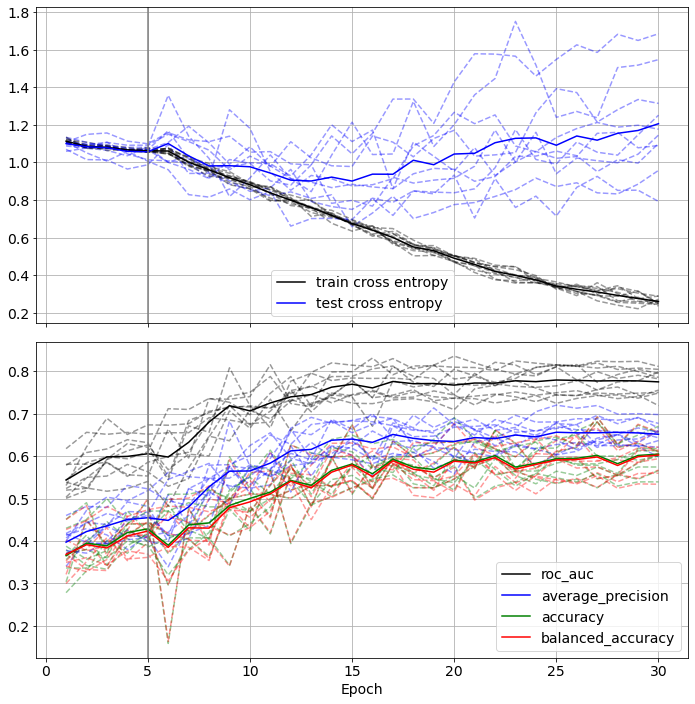

In [31]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=False)
fig.set_size_inches(10,10)
colors = {'roc_auc': 'k', 'average_precision': 'blue', 'accuracy': 'green', 'balanced_accuracy': 'red'}
x = np.arange(1,num_epochs+1)
for ix, s in enumerate(split_results):
    # cross entropy loss plots
    ax[0].plot(x, s['train_loss'], color='k', linestyle='--', alpha = 0.4)
    ax[0].plot(x, s['test_loss'], color='b', linestyle='--', alpha = 0.4)    
    
    df_met = pd.DataFrame(s['metrics'])
    for col in df_met.columns:
        ax[1].plot(x, df_met[col], color=colors[col], linestyle='--', alpha=0.4)
        
# plot averages
ax[0].plot(x, train_losses.mean(axis=0), color='k', label='train cross entropy')
ax[0].plot(x, test_losses.mean(axis=0), color='b', label='test cross entropy')
for col in df_met_agg.columns:
    ax[1].plot(x, df_met_agg[col], color=colors[col], label=col)
    
ax[1].set_xlabel('Epoch')

for a in ax:
    a.axvline(x=unfreeze_after_n, color='gray')
    a.grid()
    a.legend()
    
plt.tight_layout()